### This hidden cell allows us to access data files in the Watson Studio project assets

In [1]:
# @hidden_cell
# The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
from project_lib import Project
project = Project(project_id='2780f1e4-61c7-4596-82fc-208d1529cfc2', project_access_token='p-7e3857e98f5324b1f2a9d3fc2a2469de6de3f7bb')
pc = project.project_context


### For local setup, specify the data directory here

In [176]:
datadir = "/Users/annejones/Downloads/"
start_year = 2014
end_year = 2018
years_str = "_" + str(start_year) + "_" + str(end_year) 

# Tutorial: Create MARA malaria map (advanced)

# PART 2: Create and plot MARA transmission suitability

This notebook series demonstrates how to:  
(1) Query PAIRS using a user-defined function to return monthly climatologies for temperature and rainfall, for a user-specified polygon  
(2) Create a MARA map of suitability for malaria transmission for the queried data, using numpy (helper functions to calculate the constituent layers are provided)  
(3) For both, (1) and (2), Plot the results as a static image using matplotlib and an interactive map using folium 

## MARA algorithm

The code calculates the MARA suitability model
(Craig et al, 1999, Parasitology Today, "A Climate-based Distribution Model of Malaria Transmission in Sub-Saharan Africa") 

The input climate datasets are raster datasets (maps) consisting of :  
- climatology (i.e. long term average) of monthly mean temperature and rainfall
- climatology (i.e. long term average) of monthly mean of daily minimum temperature  

Steps to calculate suitability for malaria transmission for each grid point:  

1. Tmin of the coldest month (1-12) in the year is calculated
2. The MARA fuzzy suitability (YR) of each month is calculated for mean rainfall
3. The MARA fuzzy suitability (YT) of each month is calculated for mean temperature.
4. The overall combined fuzzy suitability (Y) of each month for mean temperature and rainfall is calculated
5. The fuzzy suitability for Tmin of the coldest month is calculated
6. The MARA conditions for multiple months are applied to the results for step (4) to calculate the highest suitability spanning 5 consecutive months, for mean temperature and rainfall - generating a single map (Ymap)
7. The conditions for Tmin are combined with the map from step (6), generating the final map (Ymap.

### Load basic libraries

In [87]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from datetime import datetime
import json

## Load the pre-queried climate data and metdata
TODO: Load from Watson Studio Data Assets

In [177]:
# Local version
def load_data(datadir, layer_str):
    data=None
    for i in range(12):
        file_name =  'data_' + layer_str + '_' + str(i).zfill(2) + years_str + '.csv'
        datanew = pd.read_csv(datadir + file_name, header=None).values
        datanew = datanew.reshape(datanew.shape[0], datanew.shape[1], 1)
        if i>0:
            data = np.concatenate([data, datanew], axis=2)
        else:
            data = datanew
    return data

In [178]:
layer_str = 'CHIRPS rainfall'
dataR = load_data(datadir, layer_str)

In [179]:
layer_str = 'ERA5 temperature'
dataT = load_data(datadir, layer_str)

In [ ]:
layer_str = 'ERA5 mintemperature'
dataTmin = load_data(datadir, layer_str)

### Get the metadata (just load a single file to get the spatial info)

In [180]:
i=1
layer_str = 'CHIRPS rainfall'
with open(datadir + 'metadata_' + layer_str + '_' + str(i).zfill(2) + years_str + '.txt') as file:
    metadata = json.load(file)

In [181]:
bbox = metadata['boundingBox']
extent = [bbox['minLongitude'], bbox['maxLongitude'], bbox['minLatitude'], bbox['maxLatitude']]

In [182]:
nx = dataR.shape[1]
ny = dataR.shape[0]
nmonths = 12

## Data pre-processing - convert temperature to deg C and mm of rainfall per month

In [183]:
dataT = dataT - 273.15

In [184]:
dataR = dataR*30.0

## Functions to calculate fuzzy suitability for each climate variable
Functions define pointwise suitability for each element in the supplied array

In [185]:
def rainfall_suitability(Rval):
    if np.isnan(Rval):
        return np.nan
    UR=1.0 
    SR=80.0
    if Rval < UR:
        YR = 0.0 
    else: 
        if Rval > SR:
            YR = 1.0
        else:
            YR = 1.0-(math.cos(((Rval-UR)/(SR-UR))*math.pi/2.0))**2
    return YR

### Generate a plot to illustrate fuzzy suitability for rainfall

In [186]:
vfunc = np.vectorize(rainfall_suitability)
rvals = [x for x in range(0, 100)]
svals = vfunc(rvals)
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x = rvals,
        y = svals)
)
fig.update_layout(xaxis_title = "Monthly Rainfall (mm)")
fig.update_layout(yaxis_title = "Suitability")
fig.show()

In [187]:
def temperature_suitability(Tval):
    if np.isnan(Tval):
        return np.nan
    UTi=18.0
    STi=22.0
    STd=32.0
    UTd=40.0
    if Tval < UTi:
        YT = 0.0
    else: 
        if Tval < STi:
            YT = 1-((math.cos(((Tval-UTi)/(STi-UTi))*math.pi/2.0))**2)
        else:
            if Tval <= STd:
                YT = 1.0
            else: 
                if Tval <= UTd:
                    YT = 1-((math.cos(((Tval-UTd)/(STd-UTd))*math.pi/2.0))**2)
                else:
                    YT = 0.0
    return YT

In [188]:
vfunc = np.vectorize(temperature_suitability)
tvals = np.linspace(10,40,300)
svals = vfunc(tvals)
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x = tvals,
        y = svals)
)
fig.update_layout(xaxis_title = "Monthly Mean Temperature (deg C)")
fig.update_layout(yaxis_title = "Suitability")
fig.show()

## Combined suitability for rainfall and temperature: take the minimum

In [189]:
def tr_suitabilty(YT, YR):
    if np.isnan(YT) | np.isnan(YR):
        return np.nan
    if YT < YR:
        Y = YT
    else:
        Y = YR
    return Y

## Suitability according to (daily) Tmin of coldest month 

In [190]:
def tmin_suitability(Tminval):
    if np.isnan(Tminval):
        return np.nan
    U=4.0
    S=6.0
    if Tminval < U:
        YTmin = 0.0
    else:
        if Tminval < S:
            YTmin = 1 - (math.cos(((Tminval-U)/(S-U))*math.pi/2))**2
        else:
            YTmin = 1.0
    return YTmin

In [191]:
vfunc = np.vectorize(tmin_suitability)
tvals = np.linspace(2,8,100)
svals = vfunc(tvals)
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x = tvals,
        y = svals)
)
fig.update_layout(xaxis_title = "Minimum Temperature (deg C)")
fig.update_layout(yaxis_title = "Suitability")
fig.show()

## Apply functions to T and R data arrays for each month and overall suitability

In [192]:
vfunc = np.vectorize(rainfall_suitability)
YR = vfunc(dataR)

In [193]:
vfunc = np.vectorize(temperature_suitability)
YT = vfunc(dataT)

In [194]:
vfunc = np.vectorize(tr_suitabilty)
Y = vfunc(YT, YR)

## Calculate Tmin suitability TODO - CREATE MONTHLY TMIN

In [198]:
# vfunc = np.vectorize(tmin_suitability)
# YTmin = vfunc(Tmin)

## Combine suitability across monthly to generate a single map

### Function to handle suitability across time - find the maximum value sustained for n months

In [ ]:
def monthly_conditions(Y_m, n = 5, tol = 0.1):
    if not np.isnan(Y_m).all():
        #print('finding suitability')
        MaxVal = 1.0
        found = False
        ymap_val=np.nan
        while found==False:
            for imonth in range(12):
                ielt = list(range(imonth, imonth+n))
                for i in range(n):
                    if ielt[i] > 11:
                        ielt[i] = ielt[i] - 12
                if np.all(Y_m[ielt] >= MaxVal):
                    ymap_val = MaxVal
                    found = True
            MaxVal = MaxVal - tol
        if found==False:
            ymap_val = 0.0
    else:
        return np.nan
    if ymap_val < 0.0:
        ymap_val = 0.0
    return ymap_val

## Compute the final map
Note in the pan-Africa model 3 or 5 months are used for the suitability conditions, depending on latitude. For this example we use 5 consecutive months as all the locations are south of 8N

### Calculate suitability across months
If this is slow, tol can be increased (e.g. to 0.1) for lower precision and faster computation

In [196]:
Ymap = np.empty([ny, nx])
for i in range(Ymap.shape[0]):
    for j in range(Ymap.shape[1]):
        Ymap[i,j] = monthly_conditions(Y[i,j,:], n = 5, tol = 0.01) 

### Combine with Tmin

In [197]:
Ymap = np.minimum(Ymap, YTmin)

NameError: name 'YTmin' is not defined

## Plot the results - Panel plot for multiple months

In [ ]:

layer_str = 'Rainfall suitability'
fig, axs = plt.subplots(4, 3, True, True, figsize = (16, 16))
monthnames=['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL',
           'AUG', 'SEP', 'OCT', 'NOV', 'DEC']
ix=0
iy=0
vmin = np.nanmin(YR)
vmax = np.nanmax(YR)
print(vmin, vmax)
for i in range(12):
    plot = axs[ix, iy].imshow(YR[:,:,i], extent=extent, cmap="bwr", vmin=vmin, vmax=vmax)
    axs[ix,iy].set_title(layer_str + ' for ' + monthnames[i])
    fig.colorbar(plot, ax=axs[ix,iy])
    i+=1
    iy+=1
    if iy>2:
        ix+=1
        iy=0
plt.show()

In [ ]:
layer_str = 'Temperature suitability'
fig, axs = plt.subplots(4, 3, True, True, figsize = (16, 16))
monthnames=['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL',
           'AUG', 'SEP', 'OCT', 'NOV', 'DEC']
ix=0
iy=0
vmin = np.nanmin(YT)
vmax = np.nanmax(YT)
print(vmin, vmax)
for i in range(12):
    plot = axs[ix, iy].imshow(YT[:,:,i], extent=extent, cmap="bwr", vmin=vmin, vmax=vmax)
    axs[ix,iy].set_title(layer_str + ' for ' + monthnames[i])
    fig.colorbar(plot, ax=axs[ix,iy])
    i+=1
    iy+=1
    if iy>2:
        ix+=1
        iy=0
plt.show()

<ipython-input-164-80601e3926a8>:2: MatplotlibDeprecationWarning:

Passing the sharex parameter of subplots() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.



0.0 1.0


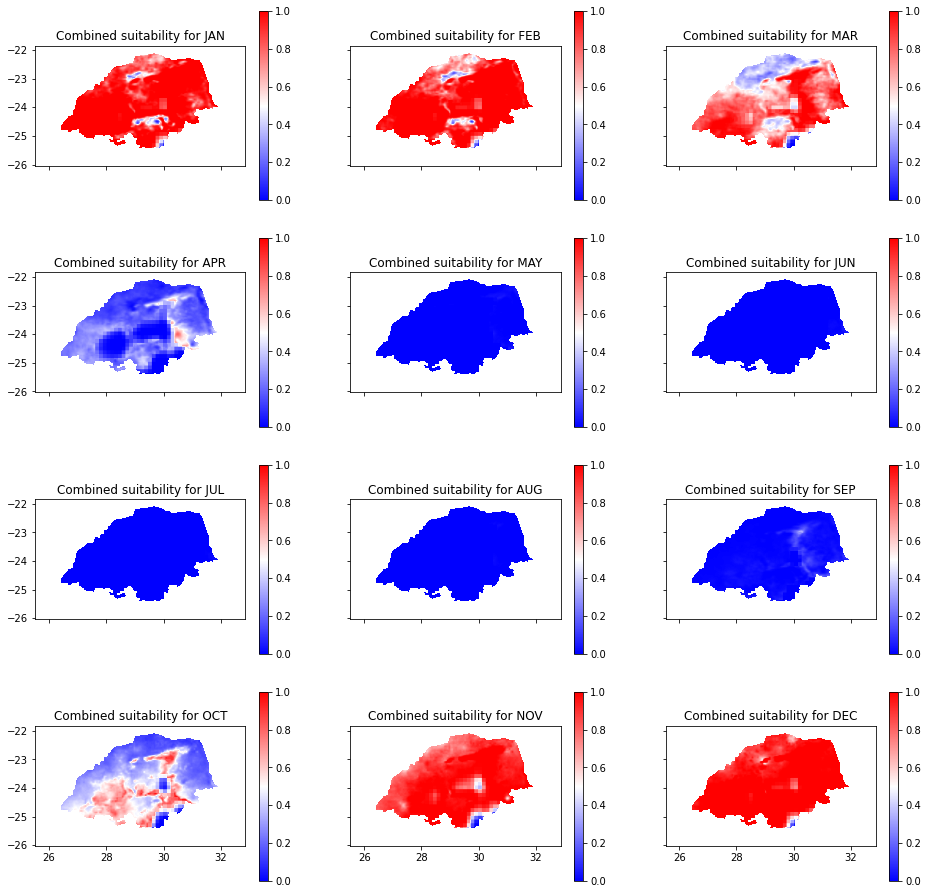

In [164]:
layer_str = 'Combined suitability'
fig, axs = plt.subplots(4, 3, True, True, figsize = (16, 16))
monthnames=['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL',
           'AUG', 'SEP', 'OCT', 'NOV', 'DEC']
ix=0
iy=0
vmin = np.nanmin(Y)
vmax = np.nanmax(Y)
print(vmin, vmax)
for i in range(12):
    plot = axs[ix, iy].imshow(Y[:,:,i], extent=extent, cmap="bwr", vmin=vmin, vmax=vmax)
    axs[ix,iy].set_title(layer_str + ' for ' + monthnames[i])
    fig.colorbar(plot, ax=axs[ix,iy])
    i+=1
    iy+=1
    if iy>2:
        ix+=1
        iy=0
plt.show()

## Final map

<ipython-input-175-05c92d389846>:2: MatplotlibDeprecationWarning:

Passing the sharex parameter of subplots() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.



0.0 1.0


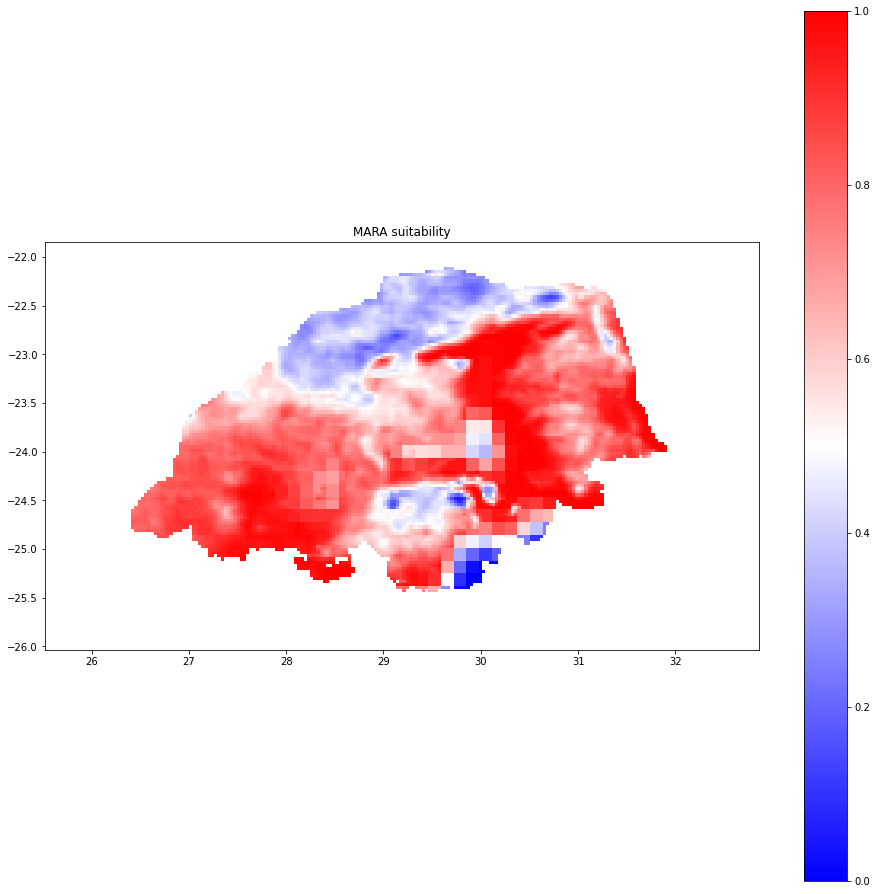

In [175]:
layer_str = 'MARA suitability'
fig, axs = plt.subplots(1, 1, True, True, figsize = (16, 16))
monthnames=['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL',
           'AUG', 'SEP', 'OCT', 'NOV', 'DEC']
ix=0
iy=0
vmin = np.nanmin(Ymap)
vmax = np.nanmax(Ymap)
print(vmin, vmax)
plot = axs.imshow(Ymap, extent=extent, cmap="bwr", vmin=vmin, vmax=vmax)
axs.set_title(layer_str)
fig.colorbar(plot, ax=axs)
plt.show()